# Vehicles Counting - HOG and SVM

The goal of this notebook is to perform vehicles counting using HOG features and SVM as classifier method. In order to do so, the following steps are:  

1. Define some inportant util functions
2. Load traning set
3. Train the SVM model
4. Apply Hog to set of test images, using a sliding window approch and selective search
5. Apply Hog to video

In [ ]:
# Probably this lines of code will work only if they are used in google colab and not localy on a user's PC
from google.colab import drive
import zipfile
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Folder where all files are
PATH_FOLDER = "/content/gdrive/MyDrive/Colab Notebooks/vehicle_counting"

In [ ]:
!gdown --id 12PuUG6pgAYH2kCf99UijQ7tSV7j_pmOD

Downloading...
From: https://drive.google.com/uc?id=12PuUG6pgAYH2kCf99UijQ7tSV7j_pmOD
To: /content/cv2.cpython-37m-x86_64-linux-gnu.so
1.01GB [00:04, 204MB/s]


In [ ]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow #we use this to show image and not cv.imshow(). This i due to the colab notebook

import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import random as rd
from sklearn.metrics import auc

from bs4 import BeautifulSoup
from imutils import paths
from collections import deque
from scipy.ndimage.measurements import label

rd.seed(1)
np.random.seed(1)

Check OpenCV version. It should be 4.5.3

In [ ]:
cv.__version__

'4.5.3-dev'

## 1.Util functions

Laod images. All images are eventually resized in order to do HOG.

In [ ]:
def extract_name(absolute_path):
    i = 0
    for j in range(len(absolute_path)):
        char = absolute_path[j]
        if char == '/' or char == '\\':
            i = j
    name = absolute_path[i+1:]
    return name

In [ ]:
def draw_boxes(img, bboxes, color=(0,255,0)):
  for (x, y, xx, yy) in bboxes:
      cv.rectangle(img, (int(x), int(y)), (int(xx), int(yy)), color, 2)

In [ ]:
def image_resize(image, width = None, height = None, inter = cv.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [ ]:
def cv2_imshow(img, title='', winSize=None):
  '''
  Function to show rgb images
  '''
  if winSize != None:
    fig, ax = plt.subplots(figsize=winSize)
  else:
    fig, ax = plt.subplots()
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)

In [ ]:
def load(path, windowsSize, color_space='rgb', folder_name='Dataset3',
         folder_negative='non-vehicles', folder_positive='vehicles'): # path = complete path to the file .zip
  with zipfile.ZipFile(path, 'r') as zip_ref:
    all_path = zip_ref.namelist()

    dic_color = {'rgb':cv.COLOR_BGR2RGB, 'gray':cv.COLOR_BGR2GRAY, 'hsv':cv.COLOR_BGR2HSV,
               'hsl':cv.COLOR_BGR2HLS, 'lab':cv.COLOR_BGR2Lab, 'luv':cv.COLOR_BGR2Luv}

    images = [] #contains all the images
    labels = [] #contains all label
    for path in all_path[1:]: #we need to skip the first path that is the name of the folder
      tmp = zip_ref.read(path)
      buffer = np.frombuffer(tmp, np.uint8) #used to decode
      if not buffer.size == 0:
        img = cv.imdecode(buffer, 1) #decode the image
        if img is not None: #check if there is an image
          if folder_name in path:
           # print(path)
            if folder_negative in path:
              labels.append(-1)
            elif folder_positive in path:
              labels.append(1)
            img = cv.resize(img, windowsSize)
            img = cv.cvtColor(img, dic_color[color_space])
            images.append(img)
    return images, labels

Function to do HOG

In [ ]:
def doHog(images):
  hog = cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

  gradients = []

  for img in images:
    gradient = hog.compute(img)
    gradients.append(gradient)
  
  return gradients
  

Function to create the svm

In [ ]:
def doSVM(X_train, y_train, save=False):
  svm = cv.ml.SVM_create()
  svm.setCoef0(0.0)
  svm.setDegree(3)
  svm.setTermCriteria((cv.TermCriteria_MAX_ITER | cv.TERM_CRITERIA_EPS, 1000, 1e-3))
  svm.setGamma(0)
  svm.setKernel(cv.ml.SVM_LINEAR)
  svm.setNu(0.5)
  svm.setP(0.1) # for EPSILON_SVR
  svm.setC(0.01) # From paper, soft classifier
  svm.setType(cv.ml.SVM_EPS_SVR) # do regression task
  svm.train(X_train, cv.ml.ROW_SAMPLE, y_train)
  if save: svm.save(PATH_FOLDER + '/svm.yml')
  return svm


Conversion from SVM to HOG detector

In [ ]:
def getHOGDetector(svm):
    sv = svm.getSupportVectors()
    rho, _, _ = svm.getDecisionFunction(0)
    sv = np.transpose(sv)
    return np.append(sv, [[-rho]], 0)

Function to compute IOU

In [ ]:
def iou(boxA, boxB):
    """
    Compute the IOU metric
    -----------------
    Parameters:
        boxA, boxB are list of corners, top left corner and bottom right corner
        in total 4 coordinates for box [x_tl, y_tl, x_br, y_br]
    Cite:
        https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    """
    # computation of top left and bottom right coordinates
    # for the interseption rectangle
    xi_1 = max(boxA[0], boxB[0])
    yi_1 = max(boxA[1], boxB[1])
    xi_2 = min(boxA[2], boxB[2])
    yi_2 = min(boxA[3], boxB[3])
    
    
    # interseption area
    area_i = max(0, xi_2 - xi_1 + 1) * max(0, yi_2 - yi_1 + 1)
    
    # areas box A and box B
    area_A = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    area_B = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # Interseption over Union
    iou = area_i / float(area_A + area_B - area_i)
    return iou

Load annotations in PASCAL VOC format

In [ ]:
#Load annotations from PASCAL VOC 
def loadAnnotations(annotPath):
  contents = open(annotPath).read()
  soup = BeautifulSoup(contents, "html.parser")
  gtBoxes = []
  # extract the image dimensions
  w = int(soup.find("width").string)
  h = int(soup.find("height").string)
  # loop over all 'object' elements
  for o in soup.find_all("object"):
    # extract the label and bounding box coordinates
    label = o.find("name").string
    xMin = int(o.find("xmin").string)
    yMin = int(o.find("ymin").string)
    xMax = int(o.find("xmax").string)
    yMax = int(o.find("ymax").string)
    # truncate any bounding box coordinates that may fall
    # outside the boundaries of the image
    xMin = max(0, xMin)
    yMin = max(0, yMin)
    xMax = min(w, xMax)
    yMax = min(h, yMax)
    # update our list of ground-truth bounding boxes
    gtBoxes.append((xMin, yMin, xMax, yMax))
  return gtBoxes


Function for hard negative mining

In [ ]:
def getHardExamples(negImagesPath, svm, stop=0):
    hardNegList = []
    hog = cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    hog.setSVMDetector(getHOGDetector(svm))
    paths_list = list(paths.list_images(negImagesPath))

    print('[Info] Number of images loaded: {}'.format(len(paths_list)))

    rootPath = negImagesPath.split(sep='/')
    rootPath = rootPath[:-1]
    annPath = ''
    for s in rootPath:
      annPath += s + '/'
    annPath += 'annotations'

    print('[Path] Images: {}'.format(negImagesPath))
    print('[Path] Annotations: {}\n'.format(annPath))

    for (i, imagePath) in enumerate(paths_list):
        # extract the filename from the file path and use it to derive
        # the path to the XML annotation file
        filename = imagePath.split(os.path.sep)[-1]
        filename = filename[:filename.rfind(".")]
        annotPath = os.path.sep.join([annPath, "{}.xml".format(filename)])
        # load the annotation file, build the soup, and initialize our
        # list of ground-truth bounding boxes
        bboxes = loadAnnotations(annotPath)
        #Load image
        image = cv.imread(imagePath)

        rects, wei = hog.detectMultiScale(image, winStride = winStride, padding=padding, scale=scale)
        for (x,y,w,h) in rects:

          keep = True
          for grect in bboxes:

            iou_area = iou(grect, (x,y,x+w,y+h))          
            if iou_area > 0:
              keep = False
              break
        
          if keep is True:          
            hardExample = image[y:y+h, x:x+w]
            hardNegList.append(cv.resize(hardExample,winSize))

        if stop > 0 and len(hardNegList) >= stop:
          break

    return hardNegList

In [ ]:
def getPositiveExamples(ImagesPath, output=0, rel_annotation='annotations'):
  # output = 0: images
  # output = 1: boxes
  # output =-1: both 
  hardPosList = []
  bboxesList = []

  paths_list = list(paths.list_images(ImagesPath))
  print('[Info] Number of images loaded: {}'.format(len(paths_list)))

  rootPath = ImagesPath.split(sep='/')
  rootPath = rootPath[:-1]
  annPath = ''
  for s in rootPath:
    annPath += s + '/'
  annPath += rel_annotation

  print('[Path] Images: {}'.format(ImagesPath))
  print('[Path] Annotations: {}\n'.format(annPath))

  for (i, imagePath) in enumerate(paths_list):
    # extract the filename from the file path and use it to derive
    # the path to the XML annotation file
    filename = imagePath.split(os.path.sep)[-1]
    filename = filename[:filename.rfind(".")]
    annotPath = os.path.sep.join([annPath, "{}.xml".format(filename)])
    # load the annotation file, build the soup, and initialize our
    # list of ground-truth bounding boxes
    bboxes = loadAnnotations(annotPath)
    bboxesList.append(bboxes)
    if output == 0 or output == -1:
      for (x1,y1,x2,y2) in bboxes:
        hardPosList.append(image[y1:y2, x1:x2])

  if output == 0: return hardPosList
  elif output == 1: return bboxesList
  elif output == -1: return hardPosList, bboxesList
  else:
    print('Error in output flag format')
    exit(-1)

Non maxima suppression fast 

In [ ]:
def fastNonMaxSuppression(boxes, sc, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return [], []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = sc
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the score of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    if len(pick) > 0: 
      scores = np.array(sc)
      scores = scores[pick].tolist()
      return boxes[pick], scores

    return [], []

Function for testing (sliding window) 

In [ ]:
def testSW(image, svm, color=(0, 0, 255), size=(400,400), th_score=0, verbose=1, save=None):
  img = image.copy()
  #Create HOG detector
  hog = cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
  svmDet = getHOGDetector(svm)
  hog.setSVMDetector(svmDet)
  rects, scores = hog.detectMultiScale(image, winStride=winStride,padding=padding, scale=scale)

  #fastNonMaxSuppression-The first parameter
  for i in range(len(rects)):
      r = rects[i]
      rects[i][2] = r[0] + r[2]
      rects[i][3] = r[1] + r[3]

  #fastNonMaxSuppression-Second parameter
  sc = [score[0] for score in scores]
  sc = np.array(sc)

  # --------- Thresholding scores
  if th_score > 0:
    rects = [rects[i] for i in range(len(rects)) if sc[i] > th_score]
    sc = [sc[i] for i in range(len(sc)) if sc[i] > th_score]

  pick = []
  scores = []
  #was 0.15
  pick, scores = fastNonMaxSuppression(np.array(rects), sc, overlapThresh = 0.15)
  #change in pick
  if verbose:
    for (x, y, xx, yy) in pick:
        cv.rectangle(img, (int(x), int(y)), (int(xx), int(yy)), color, 2)
    cv2_imshow(image_resize(img, size[1], size[0]))

  if save!=None:
    img = image_resize(img, size[1], size[0])
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    cv.imwrite( PATH_FOLDER + '/test/results/' + save, img)
  
  return pick, scores

Function for testing (selective search)

In [ ]:
def testSS(image, svm, color=(0, 0, 255), size=(400,400), th_score=0, verbose=1, blur=False, save=None):
  img = image.copy()
  #Initialize selective search
  cv.setUseOptimized(True);
  cv.setNumThreads(4);
  ss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

  if blur:
    img_blured = cv.medianBlur(img, 11)
    ss.setBaseImage(img_blured)
  else:
    ss.setBaseImage(img)

  # Switch to fast but low recall Selective Search method
  ss.switchToSelectiveSearchFast()

  #Get proposals
  rects = ss.process()

  #Classification
  scores = []
  bboxes = [] 

  for (x, y, w, h) in rects:
    img_height = img.shape[0]
    img_width = img.shape[1]
    if y+h > img_height or x+w > img_width:
      continue
    roi = cv.resize(img[y:y+h, x:x+w].copy(), winSize)
    descriptors = doHog([roi])
    descriptors = np.reshape(descriptors, (len(descriptors), len(descriptors[0])))
    #print(descriptors.shape)
    score = svm.predict(np.float32(descriptors))

    #score = svm.predict(descriptor)
    
    if np.float32(score)[1] > th_score: #is a car
      bboxes.append([x,y,w,h])
      scores.append(score)


  #fastNonMaxSuppression-The first parameter
  for i in range(len(bboxes)):
      r = bboxes[i]
      bboxes[i][2] = r[0] + r[2]
      bboxes[i][3] = r[1] + r[3]

  #fastNonMaxSuppression-Second parameter
  sc = [score[1] for score in scores]
  sc = np.array(sc)

  pick = []
  scores = []
  pick, scores = fastNonMaxSuppression(np.array(bboxes), sc, overlapThresh = 0.15)

  #change with pick
  if verbose:
    for (x, y, xx, yy) in pick:
        cv.rectangle(img, (int(x), int(y)), (int(xx), int(yy)), color, 2)
    cv2_imshow(image_resize(img, size[1], size[0]))

  if save!=None:
    img = image_resize(img, size[1], size[0])
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    cv.imwrite( PATH_FOLDER + '/test/results/' + save, img)

  return pick, scores

Performances analisys:

In [ ]:
from collections import OrderedDict

def precision_recall_curve(groundBBoxes, predictedBBoxes, confidencesList, minThreshold=0.5):
  precisions = []
  recalls = []

  # Counting the number of ground truth boxes
  num_boxes = 0
  for i in range(len(groundBBoxes)):
      num_boxes += len(groundBBoxes[i])

  # scores
  IOUs = []
  # calculate IOUs
  for i in range(len(groundBBoxes)):
    for p in predictedBBoxes[i]:
      max_iou = 0
      for g in groundBBoxes[i]:
          local_iou = iou(g,p)
          if local_iou > max_iou: 
              max_iou = local_iou
      IOUs.append(max_iou)

  confidences = []
  for i in range(len(confidencesList)):
    for c in confidencesList[i]:
      confidences.append(c)

  # Sort by confidence
  bboxes_sorted = {confidences[i]:IOUs[i] for i in range(len(confidences))}
  bboxes_sorted = OrderedDict(sorted(bboxes_sorted.items()))
  confidences_sorted = confidences.copy()
  confidences_sorted.sort(reverse=True)

  for i in range(len(bboxes_sorted)):
    
    keys = confidences_sorted[:i+1]
    IOUs_subset = []
    for k in keys:
      IOUs_subset.append(bboxes_sorted[k])

    tpr = 0                           # true posiitve rate
    fpr = 0                           # false positive rate

    for i in IOUs_subset:
      if i >= minThreshold:
        tpr += 1
      else:
        fpr += 1

    p = tpr / (tpr + fpr)             # precision
    r = tpr / num_boxes               # recall

    precisions.append(p)
    recalls.append(r)

  return precisions, recalls

## 2.Load images

In [ ]:
images = [] 
labels = [] 

'''
images_temp, labels_temp = load(PATH_FOLDER + '/Datasets/Datasets.zip', (40,40), folder_name='Dataset1', 
                       folder_negative='NegativeImages', folder_positive='PositiveImages')
images += images_temp
labels += labels_temp


images_temp, labels_temp = load(PATH_FOLDER + '/Datasets/Datasets.zip', (40,40), folder_name='Dataset2', 
                       folder_negative='non-vehicles', folder_positive='vehicles')
images += images_temp
labels += labels_temp

'''
images_temp, labels_temp = load(PATH_FOLDER + '/Datasets/Datasets.zip', (40,40), folder_name='Dataset3', 
                       folder_negative='non-vehicles', folder_positive='vehicles')
images += images_temp
labels += labels_temp

images_temp, labels_temp = load(PATH_FOLDER + '/Datasets/Front.zip', (40,40), folder_name='Dataset', 
                       folder_negative='neg', folder_positive='pos')
images += images_temp
labels += labels_temp

'''
images_temp, labels_temp = load(PATH_FOLDER + '/Datasets/dataset.zip', (40,40), folder_name='dataset', 
                       folder_negative='non-vehicles', folder_positive='vehicles')
images += images_temp
labels += labels_temp
'''

"\nimages_temp, labels_temp = load(PATH_FOLDER + '/Datasets/dataset.zip', (40,40), folder_name='dataset', \n                       folder_negative='non-vehicles', folder_positive='vehicles')\nimages += images_temp\nlabels += labels_temp\n"

In [ ]:
print(len(images))
print(len(labels))

18199
18199


In [ ]:
# Shuffle data
from sklearn.utils import shuffle
images, labels = shuffle(images, labels, random_state=1)

In [ ]:
# Convert images into gray color space
images_gray = [cv.cvtColor(img, cv.COLOR_RGB2GRAY) for img in images]

Number of images: 18199



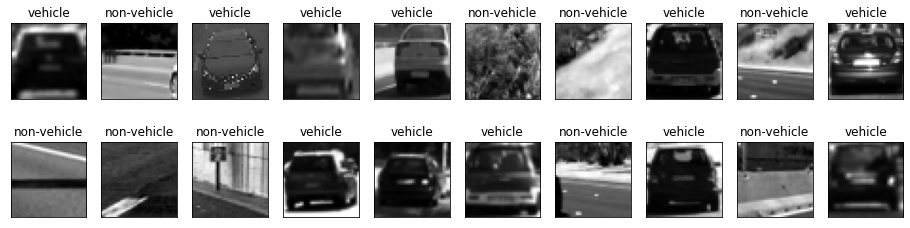

In [ ]:
rd.seed(1)

assert len(images_gray) == len(labels)
print('Number of images: {}\n'.format(len(images_gray)))

# ----------- Plot some samples
rows = 2
cols = 10
elem = rd.choices(range(len(images_gray)), k=rows*cols)
count = 0

fig, ax = plt.subplots(rows, cols, figsize=(16,4))

for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(images_gray[elem[count]], cmap='gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if int(labels[elem[count]]) == 1: text = 'vehicle'
        else: text = 'non-vehicle'
        ax[i,j].set_title(text)
        count += 1
#plt.savefig('path')

##HOG PARAMETERS

In [ ]:
#hog parameters
winSize=(40,40)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 24.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 1
nlevels = 64


#Parametri fondamentali su cui fare tuning
winStride=(2, 4)
padding=(8, 8)
scale= 1.25
threshold = 0.05

sz = (400, 400)
COMPARISON_GROUND_TRUTH = False
SAVE_RESULTS = False

## 3.Train - HOG Detector

**HOG and SVM traning**

Gray color space

In [ ]:
gradients = doHog(images_gray)

print(len(gradients))
print(len(gradients[0]))

gradients = np.reshape(gradients, (len(gradients), len(gradients[0])))
svm = doSVM(np.float32(gradients), np.float32(labels))

18199
576


In [ ]:
# Save the model
#svm.save(PATH_FOLDER + '/HOG/HOG_model.yml')

##Load SVM model

In [ ]:
svm_path = PATH_FOLDER + '/HOG/HOG_model.yml'
svm = cv.ml.SVM_load(svm_path)

## 4.1 Test - Sliding window

### Loading test images

In [ ]:
# Loading test images
folder = PATH_FOLDER + '/test/vehicles/*'

count = 1
test = []
test_filenames = []

for path in glob.glob(folder):
  img = cv.imread(path)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  test.append(img)

  file = extract_name(path)
  test_filenames.append(file)

  print('Loaded image[{}/{}]'.format(count, len(glob.glob(folder))))
  count += 1

Loaded image[1/17]
Loaded image[2/17]
Loaded image[3/17]
Loaded image[4/17]
Loaded image[5/17]
Loaded image[6/17]
Loaded image[7/17]
Loaded image[8/17]
Loaded image[9/17]
Loaded image[10/17]
Loaded image[11/17]
Loaded image[12/17]
Loaded image[13/17]
Loaded image[14/17]
Loaded image[15/17]
Loaded image[16/17]
Loaded image[17/17]


Loading bounding boxes

In [ ]:
df_boxes = pd.read_csv(PATH_FOLDER + '/test/via_region_data.csv', sep=',')
df_boxes.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,00.jpg,100055,{},16,0,"{""name"":""rect"",""x"":92,""y"":430,""width"":122,""hei...",{}
1,00.jpg,100055,{},16,1,"{""name"":""rect"",""x"":258,""y"":467,""width"":133,""he...",{}
2,00.jpg,100055,{},16,2,"{""name"":""rect"",""x"":485,""y"":493,""width"":126,""he...",{}
3,00.jpg,100055,{},16,3,"{""name"":""rect"",""x"":337,""y"":382,""width"":86,""hei...",{}
4,00.jpg,100055,{},16,4,"{""name"":""rect"",""x"":230,""y"":320,""width"":73,""hei...",{}


In [ ]:
gt_boxes = [] # Ground truth boxes

for name in test_filenames:
  boxes = []

  rows = df_boxes[ df_boxes['filename'] == name ]
  if rows['region_count'].iloc[0] > 0:
    dic_boxes = rows['region_shape_attributes'].values
    for i in range(dic_boxes.size):
      box = dic_boxes[i]
      box = box[1:-1].split(',')[1:]
      box = [int(elem.split(':')[-1]) for elem in box]
      
      # box format = [x y width height]
      x, y, width, height = box
      boxes.append([x, y, x + width, y + height])
  gt_boxes.append(boxes)

In [ ]:
print(gt_boxes[0])

[[25, 72, 86, 117], [120, 65, 177, 110], [139, 35, 178, 62], [115, 121, 216, 243], [363, 31, 478, 135], [247, 15, 278, 34], [242, 4, 267, 21], [202, 1, 227, 20], [154, 2, 180, 18], [118, 1, 142, 17], [94, 12, 126, 37]]


We use image_resize for speed up the process of vehicles detection, there the coordinates of the ground truth boxes must be changed accordingly.

In [ ]:
new_gt_boxes = []

for i in range(len(gt_boxes)):
  img = image_resize(test[i], 400)
  sz = img.shape

  if len(gt_boxes[i]) > 0:
    boxes = gt_boxes[i]
    boxes = np.array(boxes)

    col0 = boxes[:,0] / test[i].shape[1] * sz[1]
    col2 = boxes[:,2] / test[i].shape[1] * sz[1]
    col1 = boxes[:,1] / test[i].shape[0] * sz[0]
    col3 = boxes[:,3] / test[i].shape[0] * sz[0]

    boxes = np.vstack((col0.astype(int).T, col1.astype(int).T, col2.astype(int).T, col3.astype(int).T)).T

    new_gt_boxes.append(boxes.tolist())

### Test

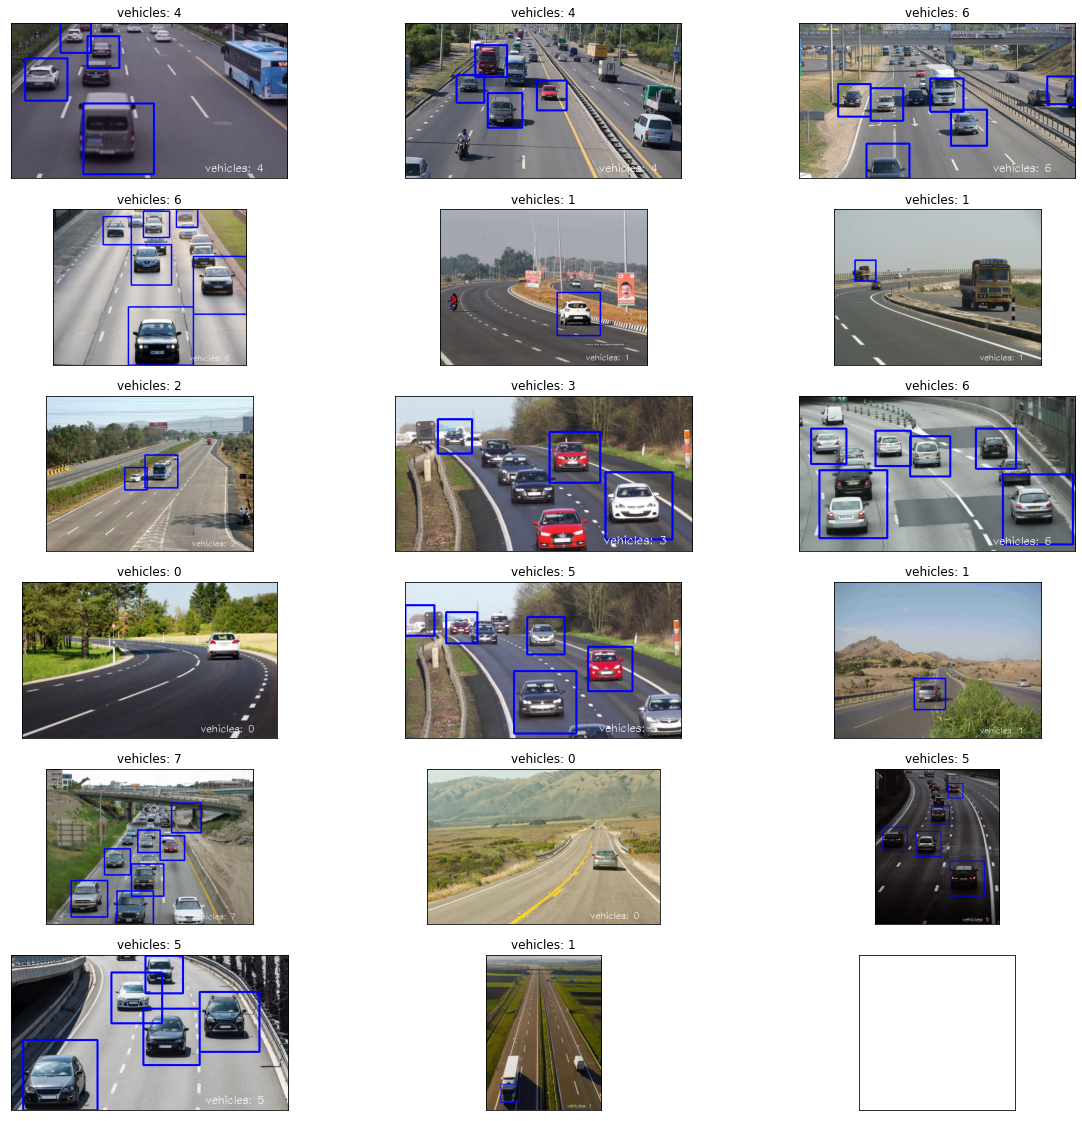

In [ ]:
cols = 3 
rows = int(np.ceil(len(test) / cols))
fig, ax = plt.subplots(rows, cols, figsize=(20,20))

predicted_boxes = []
scores = []

id = 0
for i in range(rows):
    for j in range(cols):
      if id >= len(test):
        img = np.ones((400,400,3))
        text = ''
      else:
        img = test[id].copy()

        if COMPARISON_GROUND_TRUTH:
          if len(gt_boxes[id]) > 0: draw_boxes(img, gt_boxes[id])

        img = image_resize(img, 400)
        t0 = time.time()
        bboxes, sc = testSW(img, svm, size=sz, th_score=threshold, verbose=0)
        t = time.time()

        text = '{:.4f} sec'.format(t - t0)
        draw_boxes(img, bboxes, color=(0,0,255)) 
        predicted_boxes.append(bboxes)
        scores.append(sc)

        # counting number of vehicles
        x = img.shape[1] - 120
        y = img.shape[0] - 10
        text = "vehicles: {}".format(len(bboxes))
        cv.putText(img, text, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

      ax[i,j].imshow(img)
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])
      ax[i,j].set_title(text)

      if SAVE_RESULTS and id < len(test):
        SAVING_PATH = PATH_FOLDER + '/test/results_images/HOG_sw_' + test_filenames[id]
        cv.imwrite(SAVING_PATH, cv.cvtColor(img, cv.COLOR_RGB2BGR))

      id += 1

#### Performances

In [ ]:
# threhsold for precision-recall curve
# and also for mAP
th = 0.2
precisions, recalls = precision_recall_curve(new_gt_boxes, predicted_boxes, scores, th)

In [ ]:
# Save results
if SAVE_RESULTS:
  np.savetxt(PATH_FOLDER + '/performances_analysis/HOG_SW_precisions_{}.txt'.format(th), np.array(precisions))
  np.savetxt(PATH_FOLDER + '/performances_analysis/HOG_SW_recalls_{}.txt'.format(th), np.array(recalls))

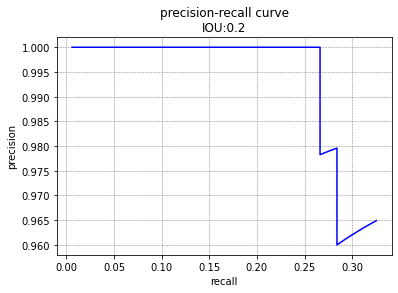

In [ ]:
#for i in range(len(precisions)):
#  print(recalls[i], ' ', precisions[i])

fig, ax = plt.subplots(1,1)
ax.plot(recalls, precisions, color='b')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.set_title('precision-recall curve\nIOU:{}'.format(th), fontsize=12)
ax.grid(color='gray', linestyle='--', linewidth=0.5)

Our only class of interest is **vehicle**, therefor in this context Average Precision (AP) and Mean Average Precision (mAP) are equivalent.

In [ ]:
mAP = auc(recalls, precisions)
print('mAP: {:.2f}%'.format(mAP * 100))

mAP: 31.76%


In [ ]:
if SAVE_RESULTS:
  f = open(PATH_FOLDER + '/performances_analysis/HOG_SW_mAP.txt', 'a')
  f.write('mAP {}: {:.2f}%\n'.format(th, mAP * 100))
  f.close()

## 4.2 Test - Selective Search

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


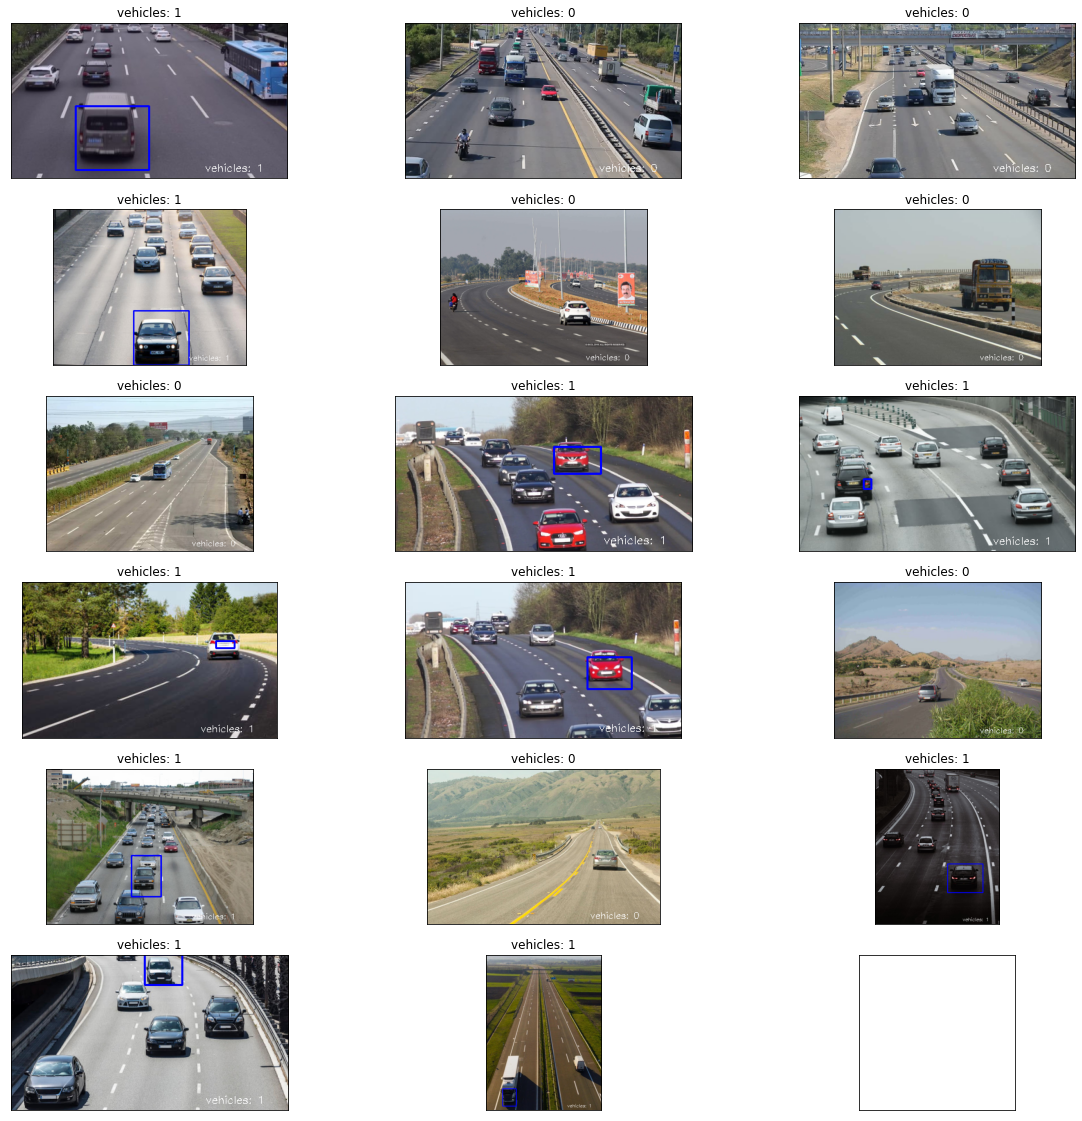

In [ ]:
cols = 3 
rows = int(np.ceil(len(test) / cols))
fig, ax = plt.subplots(rows, cols, figsize=(20,20))

predicted_boxes = []
scores = []

id = 0
for i in range(rows):
    for j in range(cols):
      if id >= len(test):
        img = np.ones((400,400,3))
        text = ''
      else:
        img = test[id].copy()

        if COMPARISON_GROUND_TRUTH:
          if len(gt_boxes[id]) > 0: draw_boxes(img, gt_boxes[id])

        img = image_resize(img, 400)
        t0 = time.time()
        bboxes, sc = testSS(img, svm, size=sz, th_score=threshold, verbose=0, blur=True)
        t = time.time()

        text = '{:.4f} sec'.format(t - t0)
        if len(bboxes) > 0: 
          draw_boxes(img, bboxes[0], color=(0,0,255))
          predicted_boxes.append(bboxes[0])
          scores.append(sc[0][0][0])
        else:
          predicted_boxes.append([])
          scores.append([])

        # counting number of vehicles
        x = img.shape[1] - 120
        y = img.shape[0] - 10
        text = "vehicles: {}".format(len(bboxes))
        cv.putText(img, text, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

      ax[i,j].imshow(img)
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])
      ax[i,j].set_title(text)

      if SAVE_RESULTS and id < len(test):
        SAVING_PATH = PATH_FOLDER + '/test/results_images/HOG_ss_' + test_filenames[id]
        cv.imwrite(SAVING_PATH, cv.cvtColor(img, cv.COLOR_RGB2BGR))

      id += 1

#### Performances

In [ ]:
# threhsold for precision-recall curve
# and also for mAP
th = 0.2
precisions, recalls = precision_recall_curve(new_gt_boxes, predicted_boxes, scores, th)

In [ ]:
# Save results
if SAVE_RESULTS:
  np.savetxt(PATH_FOLDER + '/performances_analysis/HOG_SS_precisions_{}.txt'.format(th), np.array(precisions))
  np.savetxt(PATH_FOLDER + '/performances_analysis/HOG_SS_recalls_{}.txt'.format(th), np.array(recalls))

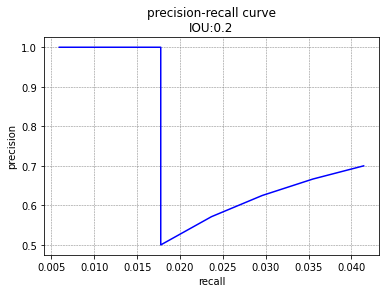

In [ ]:
#for i in range(len(precisions)):
#  print(recalls[i], ' ', precisions[i])

fig, ax = plt.subplots(1,1)
ax.plot(recalls, precisions, color='b')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.set_title('precision-recall curve\nIOU:{}'.format(th), fontsize=12)
ax.grid(color='gray', linestyle='--', linewidth=0.5)

Our only class of interest is **vehicle**, therefor in this context Average Precision (AP) and Mean Average Precision (mAP) are equivalent.

In [ ]:
if len(recalls) > 1 and len(precisions) > 1:
  mAP = auc(recalls, precisions)
else:
  mAP = 0
print('mAP: {:.2f}%'.format(mAP * 100))

mAP: 2.64%


In [ ]:
if SAVE_RESULTS:
  f = open(PATH_FOLDER + '/performances_analysis/HOG_SS_mAP.txt', 'a')
  f.write('mAP {}: {:.2f}%\n'.format(th, mAP * 100))
  f.close()

## 5.Test - Vehicle VIDEO detection & counting (SLIDING WINDOW) 

In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/vehicle_counting/HOG"
%ls

/content/gdrive/.shortcut-targets-by-id/1FU8kgF77t1RI5AuohanfZCTT4QKCjttn/vehicle_counting/HOG
CentroidTracker.py  HOG_model.yml  HogSVM.ipynb


In [ ]:
import CentroidTracker

Input video and output video



In [ ]:
inp_file= PATH_FOLDER + '/test/video/video_15sec.mp4'
out_file= PATH_FOLDER + '/test/results_video/hog_svm_15sec.mp4'

Initialize video capture and video writer

In [ ]:
cap = cv.VideoCapture(inp_file)
fps = cap.get(cv.CAP_PROP_FPS)
w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fourcc = cv.VideoWriter_fourcc(*'MP4V')
vid_writer = cv.VideoWriter(out_file, fourcc, fps, (w,h))

Video vehicle detection

In [ ]:
def count_vehicle(objects, up_line_position, down_line_position, temp, n_vehicles_up, n_vehicles_down):
  # prepare dict
  for (objectID, centroid) in objects.items():
    if centroid[1] > up_line_position and centroid[1] < down_line_position and objectID not in temp.keys():
      temp[objectID] = centroid[1]
  elim = []
  # up
  for id in temp.keys():
    #check esistence may be is eliminate
    if id not in objects.keys():
      elim.append(id)
      continue
    if objects[id][1] > down_line_position:
      n_vehicles_up += 1
      elim.append(id)
    if objects[id][1] < up_line_position:
      n_vehicles_down += 1
      elim.append(id)
  for id in elim:
    del temp[id]

  return n_vehicles_up, n_vehicles_down, temp

In [ ]:
count=0 #used to count the frames in the video 
t_in = time.time() #time to see the required time for see all the video
n_vehicles_up = 0 #initialization counting vehicles
n_vehicles_down = 0
temp = {} # vehicles between middle and up, they go down. id:y_centroid

print('Processing...')
times = []

#initialize counter
ct = CentroidTracker.CentroidTracker(maxDistance=40, maxDisappeared=40)

while cap.isOpened():
  #capture the frame
  ret, frame = cap.read()
  #check if frame read correctly
  if not ret:
    print("Exiting...")
    break

  count += 1

  t0 = time.time()
  
  #Resize the image to speed up detection, smaller size fasten the computation
  frame = image_resize(frame, 400)  
  
  bboxes, sc = testSW(frame, svm, size=sz, th_score=threshold, verbose=0)
  draw_boxes(frame, bboxes, color=(255,0,0))


  rects = []
  for box in bboxes:
    rects.append([box[0],box[1],box[2]-box[0], box[3]-box[1]])
  # update trackers
  objects = ct.update(rects)
  # loop over the tracked objects
  for (objectID, centroid) in objects.items():
		# draw both the ID of the object and the centroid of the
		# object on the output frame
    text = "ID {}".format(objectID)
    cv.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
			cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

  # draw 3 line
  middle_line_position = int(frame.shape[0]*3/4)
  up_line_position = middle_line_position - 5
  down_line_position = middle_line_position + 15
  #cv.line(frame, (0,middle_line_position), (frame.shape[1], middle_line_position), (255,255,255), 1)
  cv.line(frame, (0,up_line_position), (frame.shape[1], up_line_position), (255,255,255), 1)
  cv.line(frame, (0,down_line_position), (frame.shape[1], down_line_position), (255,255,255), 1)

  # print the count in the image
  n_vehicles_up, n_vehicles_down, temp = count_vehicle(objects, up_line_position, down_line_position, temp, n_vehicles_up, n_vehicles_down)
  
  text = "vehicles up: {}".format(n_vehicles_up)
  x = frame.shape[1] - 150
  y = 15
  cv.putText(frame, text, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
  text = "vehicles down: {}".format(n_vehicles_down)
  x = frame.shape[1] - 150
  y =  30
  cv.putText(frame, text, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)

  #Resize in order to have the same size declared in VideoWriter object
  result = cv.resize(frame, (w,h)) 
  vid_writer.write(result)
  t1 = time.time()
  #print(print("Frame {}={}".format(count,t1-t0)))
  times.append(t1-t0)

#total time to see video
t = time.time()
print("AVERAGE STATISTICS: ")
print("Time total={}".format(t-t_in))
print('Mean time for a computation: {}'.format(np.mean(times)))
print("Detection FPS={}".format(count/(t-t_in)))
print("Video FPS={}".format(fps))
vid_writer.release()
cap.release()


Processing...
Exiting...
AVERAGE STATISTICS: 
Time total=65.76685094833374
Mean time for a computation: 0.06435864814654554
Detection FPS=14.536198498405085
Video FPS=60.0
